In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import TimestampType, DoubleType
import random
from datetime import datetime, timedelta
import uuid
from pyspark.sql.functions import when, lower, trim, col


# Initialize Spark session
spark = SparkSession.builder \
    .appName("DataCleaning") \
    .getOrCreate()

In [ ]:
# Define a helper function to generate random dates
def generate_random_dates(start_date, end_date, n):
    start_timestamp = datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S")
    end_timestamp = datetime.strptime(end_date, "%Y-%m-%d %H:%M:%S")
    delta = end_timestamp - start_timestamp

    dates = []
    for _ in range(n):
        random_days = random.randint(0, delta.days)
        random_seconds = random.randint(0, 86400)  # random seconds within a day
        random_date = start_timestamp + timedelta(days=random_days, seconds=random_seconds)
        dates.append(random_date.strftime("%Y-%m-%d %H:%M:%S"))

    return dates

# Define possible values for product, category, and brand
products = [1003461, 5000088, 17302664, 3601530, 1004775, 1306894, 1306421, 1590604, 12708937, 1004258]
categories = ["electronics.smartphone", "appliances.sewing_machine", "appliances.kitchen.washer", "computers.notebook", "furniture.living_room.sofa"]
brands = ["xiaomi", "janome", "creed", "lg", "hp", "rondell", "michelin", "apple", "samsung", "huawei"]
event_types = ["view", "click", "purchase"]

# Generate sample data
n = 1000  # number of rows
start_date = "2019-11-01 00:00:00"
end_date = "2019-11-30 23:59:59"

# Generate random data
dates = generate_random_dates(start_date, end_date, n)
event_types = [random.choice(event_types) for _ in range(n)]
product_ids = [random.choice(products) for _ in range(n)]
category_codes = [random.choice(categories) for _ in range(n)]
brands = [random.choice(brands) for _ in range(n)]
prices = [round(random.uniform(20.0, 1000.0), 2) for _ in range(n)]  # random prices between 20 and 1000
user_ids = [random.randint(100000000, 999999999) for _ in range(n)]
user_sessions = [str(uuid.uuid4()) for _ in range(n)]  # generate random UUIDs

# Create the DataFrame
data = list(zip(dates, event_types, product_ids, category_codes, brands, prices, user_ids, user_sessions))
columns = ["event_time", "event_type", "product_id", "category_code", "brand", "price", "user_id", "user_session"]

df = spark.createDataFrame(data, columns)

# Show a sample of the data
df.show(5)

+-------------------+----------+----------+--------------------+------+------+---------+--------------------+
|         event_time|event_type|product_id|       category_code| brand| price|  user_id|        user_session|
+-------------------+----------+----------+--------------------+------+------+---------+--------------------+
|2019-11-11 13:06:17|  purchase|  17302664|  computers.notebook|huawei|247.94|477813263|7097d06b-3867-49d...|
|2019-11-19 01:50:31|     click|   5000088|electronics.smart...|    hp|212.12|674719555|f1664917-2477-4dc...|
|2019-11-12 17:55:19|     click|   1306894|furniture.living_...|    lg|479.72|464368375|14c2b6a8-f5dd-4d3...|
|2019-11-02 20:02:10|     click|   5000088|  computers.notebook|    lg|859.26|897437957|21e0a1c0-4307-455...|
|2019-11-23 04:13:15|      view|   1590604|appliances.sewing...| creed|126.09|968119461|78dffe30-5bad-4cd...|
+-------------------+----------+----------+--------------------+------+------+---------+--------------------+
only showi

In [ ]:
# Apply trimming and lowercase to string columns
df_cleaned = df.withColumn("event_type", lower(trim(col("event_type")))) \
               .withColumn("category_code", lower(trim(col("category_code")))) \
               .withColumn("brand", lower(trim(col("brand"))))

df_cleaned.select("event_type", "category_code", "brand").show(5)

+----------+--------------------+------+
|event_type|       category_code| brand|
+----------+--------------------+------+
|  purchase|  computers.notebook|huawei|
|     click|electronics.smart...|    hp|
|     click|furniture.living_...|    lg|
|     click|  computers.notebook|    lg|
|      view|appliances.sewing...| creed|
+----------+--------------------+------+
only showing top 5 rows



In [ ]:
# Replace "N/A", "unknown", empty strings with null
for col_name in ["category_code", "brand"]:
    df_cleaned = df_cleaned.withColumn(
        col_name,
        when(col(col_name).isin("N/A", "unknown", ""), None).otherwise(col(col_name))
    )

# Fill missing values with defaults
df_filled = df_cleaned.fillna({
    "category_code": "unspecified",
    "brand": "unbranded",
    "price": 0.0
})

df_filled.select("category_code", "brand", "price").show(5)

+--------------------+------+------+
|       category_code| brand| price|
+--------------------+------+------+
|  computers.notebook|huawei|247.94|
|electronics.smart...|    hp|212.12|
|furniture.living_...|    lg|479.72|
|  computers.notebook|    lg|859.26|
|appliances.sewing...| creed|126.09|
+--------------------+------+------+
only showing top 5 rows



In [ ]:
# Convert 'event_time' to Timestamp and ensure 'price' is float
df_typed = df_filled.withColumn("event_time", col("event_time").cast(TimestampType())) \
                    .withColumn("price", col("price").cast(DoubleType()))

df_typed.printSchema()
df_typed.select("event_time", "price").show(5)

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: long (nullable = true)
 |-- category_code: string (nullable = false)
 |-- brand: string (nullable = false)
 |-- price: double (nullable = false)
 |-- user_id: long (nullable = true)
 |-- user_session: string (nullable = true)

+-------------------+------+
|         event_time| price|
+-------------------+------+
|2019-11-11 13:06:17|247.94|
|2019-11-19 01:50:31|212.12|
|2019-11-12 17:55:19|479.72|
|2019-11-02 20:02:10|859.26|
|2019-11-23 04:13:15|126.09|
+-------------------+------+
only showing top 5 rows



The objective of this code is to demonstrate the process of data cleaning and exploration using PySpark and Pandas with Seaborn visualization. The code focuses on handling a simulated dataset containing various event data related to products, their categories, brands, prices, and timestamps.

In [ ]:
# Select key columns for exploration
df_key_columns = df_filled.select('category_code', 'brand', 'price', 'event_time')
df_key_columns.show(5)

+--------------------+------+------+-------------------+
|       category_code| brand| price|         event_time|
+--------------------+------+------+-------------------+
|  computers.notebook|huawei|247.94|2019-11-11 13:06:17|
|electronics.smart...|    hp|212.12|2019-11-19 01:50:31|
|furniture.living_...|    lg|479.72|2019-11-12 17:55:19|
|  computers.notebook|    lg|859.26|2019-11-02 20:02:10|
|appliances.sewing...| creed|126.09|2019-11-23 04:13:15|
+--------------------+------+------+-------------------+
only showing top 5 rows



In [ ]:
# Convert the PySpark DataFrame to a Pandas DataFrame
df_pandas = df_key_columns.toPandas()

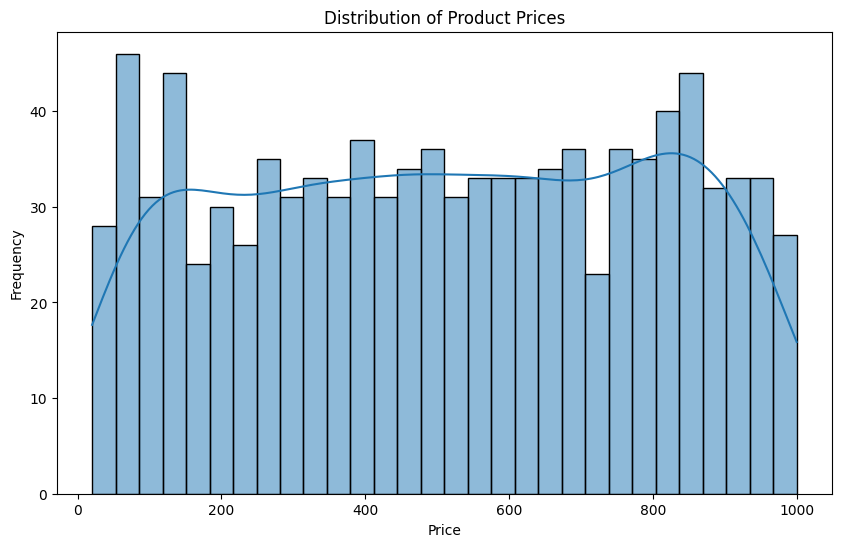

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of price
plt.figure(figsize=(10,6))
sns.histplot(df_pandas['price'], kde=True, bins=30)
plt.title('Distribution of Product Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

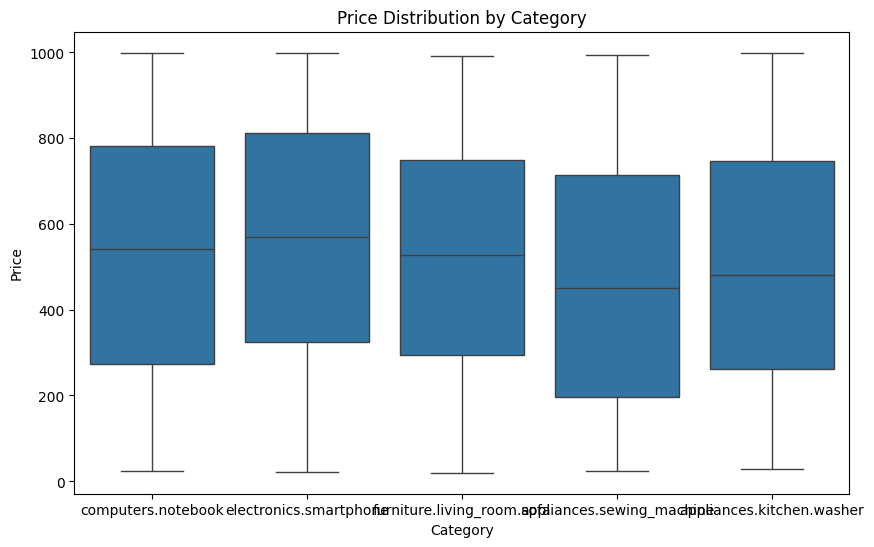

In [ ]:
#Price vs Category (Box Plot)
#A box plot can help visualize the distribution of prices within different categories.

# Boxplot for price across categories
plt.figure(figsize=(10,6))
sns.boxplot(data=df_pandas, x='category_code', y='price')
plt.title('Price Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Price')
plt.show()

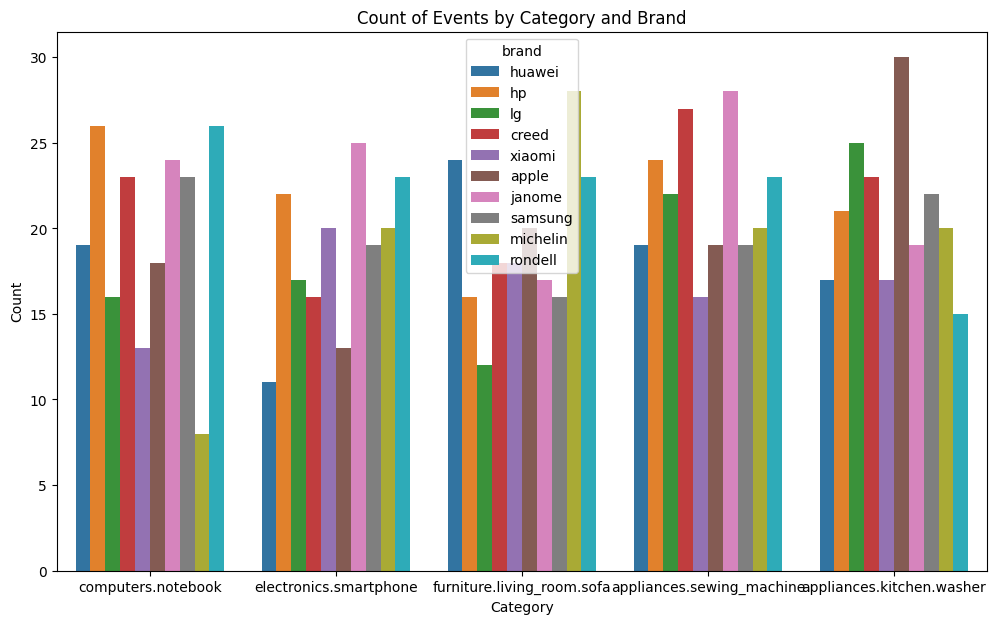

In [ ]:
#Count of Events by Category and Brand (Count Plot)
# You can also visualize the count of events for each combination of category and brand using a count plot.

# Count plot for events by category and brand
plt.figure(figsize=(12,7))
sns.countplot(data=df_pandas, x='category_code', hue='brand')
plt.title('Count of Events by Category and Brand')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()